In [100]:
%matplotlib inline
from fastai import *
from fastai.text import *
from fastai.callbacks import *

In [101]:
import numpy as np
from pathlib import Path
import os
import torch.optim as optim
import random

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

# our models of choice
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig

In [102]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)
print(f'GPU is available: {torch.cuda.is_available()}')

fastai version : 1.0.59
transformers version : 2.3.0
GPU is available: True


### Transformers model Zoo
Create a dictionary of parameters required for creating different model classes

In [103]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig),
    'albert': (AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig)
}

### Make model selection here

In [104]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

pretrained_model_name = 'albert-base-v2'
model_type = 'albert'

# model_type = 'roberta'
# pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [105]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [106]:
# We have select the basic bert-base-uncased here
# Note that Hugging face provice many choice for pretrained bert models.
model_class.pretrained_model_archive_map.keys()

dict_keys(['albert-base-v1', 'albert-large-v1', 'albert-xlarge-v1', 'albert-xxlarge-v1', 'albert-base-v2', 'albert-large-v2', 'albert-xlarge-v2', 'albert-xxlarge-v2'])

### Use the same randomization seed so as to compare different models more easily

In [107]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
seed_all(seed)

### Data pre-processing
The important thing here is that `FastAI` uses **processors** to perform repeatetive tasks when creating `DataBunch`. A set of default **processors** are performed for fastai.textlearners. For example:
  

In [108]:
# FastAI use various processors to perform repeatative tasks in data pipeline

def _get_processor(tokenizer:Tokenizer=None, vocab:Vocab=None, chunksize:int=10000, max_vocab:int=60000,
                   min_freq:int=2, mark_fields:bool=False, include_bos:bool=True, include_eos:bool=False):
    return [TokenizeProcessor(tokenizer=tokenizer, chunksize=chunksize, 
                              mark_fields=mark_fields, include_bos=include_bos, include_eos=include_eos),
            NumericalizeProcessor(vocab=vocab, max_vocab=max_vocab, min_freq=min_freq)]

class NumericalizeProcessor(PreProcessor):
    "`PreProcessor` that numericalizes the tokens in `ds`."
    def __init__(self, ds:ItemList=None, vocab:Vocab=None, max_vocab:int=60000, min_freq:int=3):
        vocab = ifnone(vocab, ds.vocab if ds is not None else None)
        self.vocab,self.max_vocab,self.min_freq = vocab,max_vocab,min_freq

    def process_one(self,item): return np.array(self.vocab.numericalize(item), dtype=np.int64)
    def process(self, ds):
        if self.vocab is None: self.vocab = Vocab.create(ds.items, self.max_vocab, self.min_freq)
        ds.vocab = self.vocab
        super().process(ds)

#### We need to overwrite the "tokenizer" and "numericalizer" in order to tailor the databunch creating process to the `Transformers`
Later when creating `DataBunch`, we are going to pass in our customized processors

## Tokenizer
Step 1: create a new tokenizer that inherit from `fastai`'s `BaseTokenizer`

In [109]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        # If we use roberta, add prefix_space before tokens
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

Step 2: Get the 'pre-trained tokenizer' from `transformer` library.(this is used for initialization of the class we created above)

In [110]:
# download `bert tokenizer`
# transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

Step 3: Create the actual **tokenizer** for our transformer of choice and put a `FastAI` wrapper on

In [111]:
transformer_tokenizer

In [112]:
model_type

'albert'

In [116]:
# Create Hugging Face tokenizer
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)

# Wrapper of FastAI `Tokenizer`
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In this implementation, be carefull about 3 things :

1. As we are not using RNN, we have to limit the sequence length to the model input size.
2. Most of the models require special tokens placed at the beginning and end of the sequences.
3. Some models like RoBERTa require a space to start the input string. For those models, the encoding methods should be called with add_prefix_space set to True.

Below, you can find the resume of each pre-process requirement for the 5 model types used in this tutorial. You can also find this information on the [HuggingFace documentation](https://huggingface.co/transformers/) in each model section.<br>
`bert:       [CLS] + tokens + [SEP] + padding`<br>
`roberta:    [CLS] + prefix_space + tokens + [SEP] + padding`<br>
`distilbert: [CLS] + tokens + [SEP] + padding`<br>
`xlm:        [CLS] + tokens + [SEP] + padding`<br>
`xlnet:      padding + [CLS] + tokens + [SEP]`

It is worth noting that we don't add padding in this part of the implementation.  As we will see later, fastai manage it automatically during the creation of the `DataBunch`.

## Numericalizer
In `fastai` library, `NumericalizeProcessor` object takes as `bocab` argument a `Vocab` object. Here we will create a new class `TransformerVocab` that inherits from `Vocab` and overwrite `numericalize` and `textify` functions.

In [120]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

### Customize numericalize processor
Notice taht we need to pass the `include_bs=False` and `include_eos=False` options. This is because `fastiai` adds its own special tokens by default which interferes with the `[CLS]` and `[SEP]` tokens that are required for RoBERTa

In [121]:
transformer_vocab

In [122]:
# use RoBERTa tokenizer to initialize the `TransformersVocab`
transformer_vocab = TransformersVocab(tokenizer=transformer_tokenizer)

# create a customized numericalizor using vocab just created
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)


## Put together our customized processor

In [123]:
# wrapper function over the tokenizer we created above
# Specify include_bos & include_eos to False because our tokenizer has already created them
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)


#### We need openfileprocessor since we will be doing `from_folder` for `TextList` later

In [124]:
# finally put the two processors in a list for later use
transformer_processor = [OpenFileProcessor(),tokenize_processor, numericalize_processor]

# Create DataBunch
For the DataBunch creation, you have to pay attention to set the processor argument to our new custom processor `transformer_processor` and manage correctly the padding.

As mentioned in the [HuggingFace documentation](https://huggingface.co/transformers/), BERT, RoBERTa, XLM and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. Regarding XLNET, it is a model with relative position embeddings, therefore, you can either pad the inputs on the right or on the left.

In [125]:
# If we are using Google XLNet
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id
pad_idx

0

In [132]:
tokens = transformer_tokenizer.tokenize('the cat didnt jump onto the table, because its tired')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['▁the', '▁cat', '▁didnt', '▁jump', '▁onto', '▁the', '▁table', ',', '▁because', '▁its', '▁tired']
[14, 2008, 1182, 3936, 1204, 14, 859, 15, 185, 82, 4117]


['▁the',
 '▁cat',
 '▁didnt',
 '▁jump',
 '▁onto',
 '▁the',
 '▁table',
 ',',
 '▁because',
 '▁its',
 '▁tired']

## As compared to RoBERTa

In [133]:
# tokens = transformer_tokenizer.tokenize('the cat didnt jump onto the table, because its tired')
# print(tokens)
# ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
# print(ids)
# transformer_tokenizer.convert_ids_to_tokens(ids)

## Prepare the full IMDB dataset and inspect the files under that path

In [134]:
path = untar_data(URLs.IMDB)
path

PosixPath('/home/projectx/.fastai/data/imdb')

In [135]:
path.ls()

[PosixPath('/home/projectx/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/projectx/.fastai/data/imdb/models'),
 PosixPath('/home/projectx/.fastai/data/imdb/lm_databunch_RoBERTa'),
 PosixPath('/home/projectx/.fastai/data/imdb/test'),
 PosixPath('/home/projectx/.fastai/data/imdb/data_bunch_classification'),
 PosixPath('/home/projectx/.fastai/data/imdb/imdb_textlist_classifier'),
 PosixPath('/home/projectx/.fastai/data/imdb/fine_tuning_LM'),
 PosixPath('/home/projectx/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/projectx/.fastai/data/imdb/train'),
 PosixPath('/home/projectx/.fastai/data/imdb/lm_databunch'),
 PosixPath('/home/projectx/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/projectx/.fastai/data/imdb/README'),
 PosixPath('/home/projectx/.fastai/data/imdb/unsup')]

In [136]:
(path/'train').ls()

[PosixPath('/home/projectx/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/pos'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/neg')]

In [137]:
(path/'test').ls()

[PosixPath('/home/projectx/.fastai/data/imdb/test/pos'),
 PosixPath('/home/projectx/.fastai/data/imdb/test/labeledBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/test/neg')]

# Create DataBunch for classification

In [138]:
transformer_vocab

In [139]:
# we can play around with the batch_size as long as the GPU can take it
bs = 16
data_clas = (TextList.from_folder(path, vocab=transformer_vocab, processor=transformer_processor)                         # specify the path
           .filter_by_folder(include=['train','test'])# exclude other folders
           .split_by_folder(valid='test')                 #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
           .label_from_folder(classes=['neg', 'pos'])                    #label them all with their folders
           .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))                                 # convert to databunch for the learner later

In [140]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
data_clas.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : <pad>


text,target
"[CLS] ▁there ▁isn ' t ▁one ▁decent ▁scene . <unk> br ▁ / <unk> br ▁ / <unk> a my ▁adams ▁gives ▁one ▁of ▁the ▁worst ▁performances ▁of ▁all ▁time . ▁proof ▁that ▁you ▁a ▁can ▁start ▁anywhere . ▁the ▁guy ▁playing ▁sebastian ▁suck s , ▁too . ▁he ▁doesn ' t ▁even ▁look ▁much ▁like ▁ryan ▁phillip e . ▁more ▁like ▁joshua ▁jackson . ▁the ▁two ▁other ▁girls ▁are",neg
"[CLS] ▁i ▁was ▁aware ▁of ▁roh mer ' s ▁admiration ▁for ▁the ▁late ▁works ▁of ▁the ▁one s ▁he ▁considered ▁like ▁great ▁ cin east s , ▁and ▁that ▁normal ▁spectators ▁generally ▁considered ▁as ▁artistic ▁failure s ▁ ( as ▁reno ir ' s ▁or ▁chaplin ' s ▁very ▁last ▁movies ▁ ; ▁yes , ▁the ▁ "" poli tique ▁des ▁a ute urs "" ▁also ▁has ▁its ▁dark ▁side",neg
"[CLS] ▁i ▁saw ▁this ▁movie ▁literally ▁directly ▁after ▁finishing ▁the ▁book , ▁and ▁maybe ▁that ▁was ▁a ▁neutral ▁idea ▁or ▁a ▁very ▁stupid ▁one . ▁i ▁think ▁it ▁was ▁the ▁latter . ▁first ▁of ▁all , ▁it ▁was ▁inaccurate ▁in ▁many ▁small , ▁yet ▁important ▁details . ▁one ▁of ▁the ▁first ▁things ▁i ▁noticed ▁was , ▁during ▁winston ' s ▁day ▁to ▁day ▁life ▁in ▁his ▁work , ▁his ▁conversations",neg
"[CLS] ▁ ( there ▁are ▁spoil ers ) ▁homi cid al ▁nymph o maniac ▁hooker ▁ miya , ▁ kari ▁wu hr er , take s ▁over ▁the ▁life ▁and ▁car ▁of ▁18 ▁virgin , ▁even ▁though ▁he ' s ▁too ▁embarrassed ▁to ▁admit ▁it , ▁collage ▁freshmen ▁trent ▁colbert , ▁kristof fer ▁ryan . ▁by ▁the ▁end ▁of ▁the ▁movie ▁my ia ▁not ▁only ▁de flower s ▁but ▁give",neg
"[CLS] ▁i ▁bought ▁the ▁dvd ▁of ▁before ▁sunset ▁and ▁saw ▁it ▁for ▁the ▁first ▁time ▁a ▁week ▁ago . ▁having ▁saw ▁it ▁twice , ▁i ▁couldn ' t ▁help ▁but ▁missing ▁before ▁sunrise , ▁not ▁because ▁the ▁sequel ▁was ▁not ▁as ▁great , ▁but ▁i ▁felt ▁that ▁these ▁two ▁movies ▁completed ▁each ▁other ▁like ▁no ▁other ▁sequel s ▁ever ▁did , ▁every ▁time ▁i ▁finished ▁watching ▁one ▁of ▁them ,",pos


Check numericalization

In [141]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = data_clas.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 2
[SEP] id : 3
[PAD] id : 0
Batch shape :  torch.Size([16, 512])
tensor([[    2,    13,     7,  ...,    18,  3839,     3],
        [    2,    13,     7,  ...,   171,  7782,     3],
        [    2,   382,   685,  ..., 17516,    59,     3],
        ...,
        [    2,    48,    25,  ...,  6939,    24,     3],
        [    2,    25,    32,  ...,  5145,    13,     3],
        [    2,    14,   609,  ...,    15, 26804,     3]])


In [84]:
# # From RoBERTa
# print('[CLS] id :', transformer_tokenizer.cls_token_id)
# print('[SEP] id :', transformer_tokenizer.sep_token_id)
# print('[PAD] id :', pad_idx)
# test_one_batch = data_clas.one_batch()[0]
# print('Batch shape : ',test_one_batch.shape)
# print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([16, 512])
tensor([[    0,    22,  4688,  ...,  2101,    33,     2],
        [    0,    22, 18764,  ...,     9, 13084,     2],
        [    0,  3128,  2115,  ...,  3171,     9,     2],
        ...,
        [    0,  1534,    24,  ...,    99,    16,     2],
        [    0,    20,   527,  ...,    39,  3793,     2],
        [    0,    38,    56,  ...,    45,    14,     2]])


In [142]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        logits = self.transformer(input_ids,
                                attention_mask = attention_mask)[0]   
        return logits

In [152]:
a = {"0":"0",
     "1":"1"}
print(a)

{'0': '0', '1': '1'}


In [161]:
config.label2id

{'LABEL_0': 0, 'LABEL_1': 1}

In [160]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
# config.id
config.use_bfloat16 = use_fp16
print(config)

{
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "num_memory_blocks": 0,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 0,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "temperature": 1.0,
  "top_k": 50,


In [144]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

### Create a learner with pre-trained weights from `Hugging Face` but not from IMDB

In [88]:
# # Load the fine-tuned encoder weights
# name = 'learn_lm_encoder_IMDB'
# custom_transformer_model.transformer.roberta.load_state_dict(torch.load(path/'models'/f'{name}.pth', map_location=None))

In [146]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(data_clas, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [147]:
print(learner.model)

CustomTransformerModel(
  (transformer): AlbertForSequenceClassification(
    (albert): AlbertModel(
      (embeddings): AlbertEmbeddings(
        (word_embeddings): Embedding(30000, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): AlbertTransformer(
        (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
        (albert_layer_groups): ModuleList(
          (0): AlbertLayerGroup(
            (albert_layers): ModuleList(
              (0): AlbertLayer(
                (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                (attention): AlbertAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768

# Very important thing to note here:
We can't seperate the layers in the same way as we did with RoBERTa or BERT.
The reason is that **ALBERT** adopts **Cross-layer parameter sharing** (this is one of the two approaches the authors applied to reduce the number of parameters). Hence, we do not have *11 layers of `BertEncoder`'s parameters*. Rather, we just need to put them in **one layer bracket**.

In [51]:
# For xlnet-base
list_layers = [learner.model.transformer.transformer.word_embedding,
              learner.model.transformer.transformer.layer[0],
              learner.model.transformer.transformer.layer[1],
              learner.model.transformer.transformer.layer[2],
              learner.model.transformer.transformer.layer[3],
              learner.model.transformer.transformer.layer[4],
              learner.model.transformer.transformer.layer[5],
              learner.model.transformer.transformer.layer[6],
              learner.model.transformer.transformer.layer[7],
              learner.model.transformer.transformer.layer[8],
              learner.model.transformer.transformer.layer[9],
              learner.model.transformer.transformer.layer[10],
              learner.model.transformer.transformer.layer[11],
              learner.model.transformer.sequence_summary,
              learner.model.transformer.logits_proj]

In [91]:
# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [148]:
# for ALBERT, we divide it into 4 layer groups with all BERT encoders inside one single group
list_layers = [learner.model.transformer.albert.embeddings,
               learner.model.transformer.albert.encoder,
               learner.model.transformer.albert.pooler,
               learner.model.transformer.dropout]

In [149]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 4 groups
[Sequential(
  (0): Embedding(30000, 128, padding_idx=0)
  (1): Embedding(512, 128)
  (2): Embedding(2, 128)
  (3): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=128, out_features=768, bias=True)
  (1): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Linear(in_features=768, out_features=768, bias=True)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=768, out_features=768, bias=True)
  (7): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (8): Linear(in_features=768, out_features=3072, bias=True)
  (9): Linear(in_features=3072, out_features=768, bias=True)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Tanh()
), Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=768,

In [47]:
learner.save('untrained_albert_classifier')

In [ ]:
learner.load('untrained_classifier')

In [150]:
learner.freeze()
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


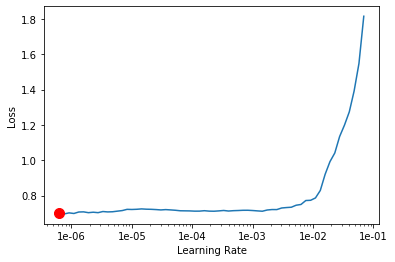

In [151]:
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.595728,0.421218,0.796560,0.203440,09:05
1,0.549520,0.309896,0.883680,0.116320,09:18
2,0.519476,0.318946,0.870000,0.130000,09:28
3,0.481961,0.274421,0.894760,0.105240,09:29


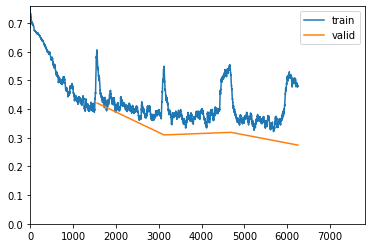

KeyboardInterrupt: 

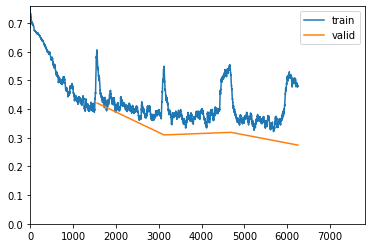

In [96]:
learner.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

In [51]:
learner.save('albert-no-pre-training-freezed')

In [40]:
# learner.load('no-pre-training-freezed');

## we only have 4 layer groups

In [52]:
len(learner.layer_groups)

4

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 2.29E-07


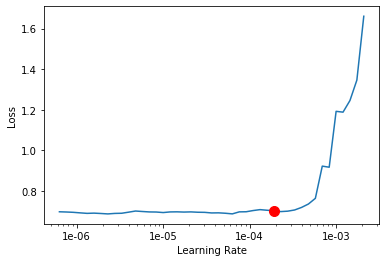

In [53]:
# since we have 14 layer_groups, we will unfreeze 2-3 layers to speed up the process
learner.freeze_to(-2)
torch.cuda.empty_cache()
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.188021,0.154190,0.942720,0.057280,11:49
1,0.149319,0.136903,0.949360,0.050640,11:14
2,0.119082,0.133555,0.951440,0.048560,11:13


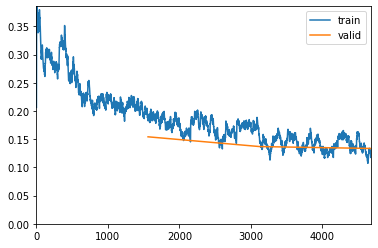

In [47]:
# ignore suggestion
learner.fit_one_cycle(3, 5e-5, moms=(0.8,0.7))

In [48]:
learner.save('no-pre-training-freez_to_-3')

In [ ]:
# learner.load('no-pre-training-freez_to_-3');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.31E-07


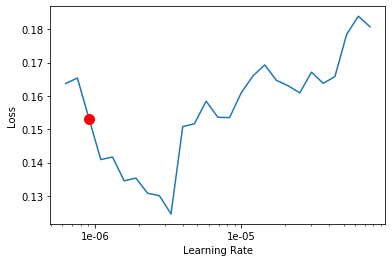

In [49]:
# since we have 14 layer_groups, we will unfreeze 2-3 layers to speed up the process
learner.freeze_to(-5)
torch.cuda.empty_cache()
learner.lr_find()
learner.recorder.plot(skip_end = 10, suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.127595,0.130388,0.952680,0.047320,11:48
1,0.127141,0.131005,0.953080,0.046920,12:39


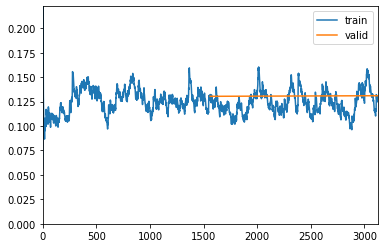

In [50]:
# ignore suggestion
learner.fit_one_cycle(2, 9.12E-07, moms=(0.8,0.7))

In [52]:
learner.save('no-pre-training-freez_to_-5')

In [38]:
learner.load('no-pre-training-freez_to_-5');

### We are able to get 95.3% accuracy without pre-finetuning

In the original guide of Jeremy Howard's ULMFiT for IMDB, he achieved **94.7%** accuracy. All the training strategies, like gradual unfreezing, learning rate annealing, batching are the same when constructing our `Learner`. Therefore, it's obvious that the `transformer` in stronger than `AWD_LSTM` for this task in terms of architecture.<br>

In the next notebook, we are going to push things further by incorporate the **ULMFiT** training procedure to the `transformer` training and see if we can get even better result.